# Local Beam Sudoku

## Modelagem

Para a modelagem do sudoku, utilizou-se a mesma abordagem utilizada por Peter Norvig(http://norvig.com/sudoku.html), onde o grid do puzzle é convertido para um dicionario(hash) que tem como chave os índices dos *squares*(casas do sudoku).  
![sudoku](sudoku_state.png)

Também são criadas listas dos *peers* referentes a um square. Os *peers* são as casas que estão na mesma linha, coluna e grid 3x3

In [3]:
import random

# definindo os elementos
digits = '123456789'
rows = 'ABCDEFGHI'
cols = digits


def cross(A, B):
    "Funcao auxiliar para realizar o produto cruzado dos elementos de A e B"
    return [a + b for a in A for b in B]


# cada square é um quadrado da matriz 9x9 do sudoku.
squares = cross(rows, cols)

# cada square tem/pertence 9 units(linha, coluna, grid/. Unitlist é a lista de todas as colunas, linhas e grids
unitlist = ([cross(rows, c) for c in cols] +
            [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC', 'DEF', 'GHI') for cs in ('123', '456', '789')])

# dicionario para retornar as units de um determinado square
units = dict((s, [u for u in unitlist if s in u]) for s in squares)

# peers de um square S sao todos os squares das 3 unidades relacionadas a S exceto o próprio S
peers = dict((s, set(sum(units[s], [])) - set([s])) for s in squares)

## Funções

Abaixo funções auxiliares para converter o grid de entrada em um dicionario com os valores utilizando a estrutura definida acima

In [4]:
def grid_hash(grid):
    """Converte a grid em um dicionario de {square: valor} com '0' or '.' para os vazios."""
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

def display(grid_dict):
    """Mostra o dict de valores no formado grid 2-D"""
    width = 1 + max(len(grid_dict[s]) for s in squares)
    line = '+'.join(['-' * (width * 3)] * 3)
    result = ''
    for r in rows:
        result += (''.join(grid_dict[r + c].center(width) + ('|' if c in '36' else '') for c in cols)) + '\n'
        if r in 'CF':
            result += line + '\n'
    result += '\n'
    return result

Função auxiliar para plotar gráfico com o resultado

In [5]:
import matplotlib.pyplot as plt

def plot_graph(X,Y,title = 'Grafico',labelX = 'Tentativa',labelY= 'Valor', color_label = 'b'):
    """Funcao que recebe um vetor X e outro Y e gera um grafico com os pontos x,y"""
    fig, ax1 = plt.subplots()
    line1 = ax1.plot(X, Y, color_label, label=labelY)
    ax1.set_xlabel(labelX)
    ax1.set_ylabel(labelY, color=color_label)
    for tl in ax1.get_yticklabels():
        tl.set_color("black")
        
    lns = line1
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 4)
    
    plt.title(title)
    plt.grid(True)
    fig.set_size_inches(15, 5, forward=True)
    plt.show()


Abaixo funções que serão utilizadas pelo algoritmo de **Feixe Local**. 

In [6]:
def possible_squares(grid_dict):
    """Retorna uma lista embaralhada de squares livres"""
    possible = [k for k, v in grid_dict.items() if v in '0.']
    random.shuffle(possible)
    return possible

def valid_digits(key,grid_dict):
    """Retorna uma lista embaralhada de possiveis digitos"""
    valid = '123456789'
    for p in peers[key]:
        if grid_dict[p] not in '0.':
            valid = valid.replace(grid_dict[p],'')
    valid = list(valid)
    random.shuffle(valid)
    return ''.join(valid)

def generate_child(grid_dict):
    """Gera um filho preenchendo uma das casas vazias validas com um valor valido"""
    child = grid_dict.copy()
    try:
        pos = possible_squares(grid_dict)[0]
        value = valid_digits(pos,grid_dict)[0]
        #TODO: ver se é necessario fazer while até encontrar posição/value 
        if(pos and value):
            child[pos] = value
    except:
        return
    
    return child

def fitness(grid_dict):
    """Função de fitness: conta a quantidade de valores possiveis por squares vagos."""
    squares = possible_squares(grid_dict)
    ps = len(squares) + 1 #soma-se 1 para proteger de divisao por zero
    pv = sum([len(valid_digits(v,grid_dict)) for v in squares])
    #return pv/ps
    return pv

def goal(grid_dict):
    """Função objetivo: conta se todos os quadrados estao prenchidos"""
    return len([k for k, v in grid_dict.items() if v in '0.']) == 0

## Execução

A implementação da **Busca por Feixe Local** é simples:  
- Intancia-se o estado inicial
- Define-se a quantidade **k** de filhos a serem gerados e selecionados a cada iteração
- Itera-se até que a condição de parada seja atingida
- Se todas as casas estiverem preenchidas, então convergiu, caso contrário chegou em uma solução inválida.

In [7]:
import random
import time

def beam_search(k,puzzle):
    #incio da contagem de tempo
    start_time = time.time()
    
    #population é uma lista de puzzles já na forma de dict
    population = []
    
    #populacao inicial
    initial = grid = grid_hash(puzzle)
    population.append(initial)
    
    generation = 1  #controle das geracores
    goal_call = 0   #controle das chamadas a funcao objetivo
    historic = []   #controle do melhor individuo de cada geracao
    
    while True:
        children = []
        for individual in population:
            for i in range(k):
                child = generate_child(individual)
                if(child is not None):
                    children.append(child)
                
        #verifica se não gerou filhos
        if(not len(children)):
            #retornar um vetor: tempo,invocaco_objetivo,vetor[(geracao,melhor_fitness)],individual
            return (time.time()-start_time, goal_call, historic, population[0])
        
        #ordena os filhos pelo fitness
        children.sort(key=lambda c: fitness(c), reverse=True)
        
        #verifica se chegou na condição de parada
        goal_call += 1
        if(goal(children[0])):
            #retornar um vetor: tempo,invocaco_objetivo,vetor[(geracao,melhor_fitness)]
            return (time.time()-start_time, goal_call, historic, children[0])
            
        #seleciona os K melhores e define como a populacao
        population = children[:k]
        
        #salva o melhor da geração
        historic.append((generation,fitness(children[0])))
        generation += 1
        
        

### Parâmetros
Como parâmetros  utilizou-se:  
- Estados gerados e estados selecionados: 3, 5, 10, 50, 100
- Condição de parada: todas as casas preenchidas ou 200 tentativas


In [8]:
INITIAL = """
        8 3 . |1 . . |6 . 5
        . . . |. . . |. 8 . 
        . . . |7 . . |9 . . 
        ------+------+------
        . 5 . |. 1 7 |. . . 
        . . 3 |. . . |2 . . 
        . . . |3 4 . |. 1 . 
        ------+------+------
        . . 4 |. . 8 |. . . 
        . 9 . |. . . |. . . 
        3 . 2 |. . 6 |. 4 7 
        """
EXECUTIONS = 200

Funções para auxiliar a execução para K's variados

In [9]:
def run(k):
    """Executa o Beam Search para um K determinado"""
    execution = 0
    converged = False
    execution_goal = []    #controle da quantidade de chamadas da função objetivo por execução
    
    while execution < EXECUTIONS:
        result = beam_search(k,INITIAL)
        tempo, goal_call, historic, final = result
        filled_spots = 81-len(possible_squares(final))
        execution_goal.append((execution, filled_spots, goal_call, historic, tempo)) #info para gerar graficos
    
        if(filled_spots == 81):
            converged = True
            print('TENTATIVA: {} \t| CONVERGIU: {}\nSOLUCAO:\n{}'.format(execution,converged, display(final)))
            break
        execution += 1
    
    total_time = sum([i[4] for i in execution_goal])
    avg_time = total_time/len(execution_goal)
    print('TEMPO TOTAL: {}s \t| TEMPO MÉDIO: {}s \t| CONVERGIU: {}'.format(round(total_time,4), round(avg_time,4), converged))
    return execution_goal

In [10]:
def plot_run(execution_goal):
    """Plota os graficos da execução do Beam Search"""
    # EXECUCAO POR CHAMADAS DA FUNCAO OBJETIVO
    X,Y = [i[0] for i in execution_goal],[i[2] for i in execution_goal]
    plot_graph(X,Y,'EXECUCAO POR CHAMADAS DA FUNCAO OBJETIVO','Execução','Chamadas','y')

    # EXECUCAO POR CASAS PREENCHIDAS PARA O MELHOR RESULTADO
    X,Y = [i[0] for i in execution_goal],[i[1] for i in execution_goal]
    plot_graph(X,Y,'EXECUCAO POR CASAS PREENCHIDAS PARA O MELHOR RESULTADO','Execução','Casas Preenchidas','g')

    # EVOLUCAO DO FITNESS POR GERACAO DO MELHOR INDIVIDUO
    execution_goal.sort(key=lambda e: e[1], reverse=True)
    best = execution_goal[0][3]
    X,Y = [i[0] for i in best],[i[1] for i in best]
    plot_graph(X,Y,'EVOLUCAO DO FITNESS POR GERACAO DO MELHOR INDIVIDUO','Geração','Fitness','b')

#### K = 3

In [11]:
execution = run(3)

TEMPO TOTAL: 48.2315s 	| TEMPO MÉDIO: 0.2412s 	| CONVERGIU: False


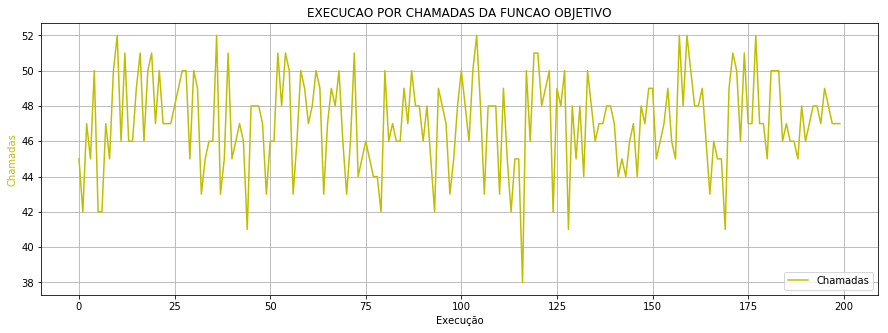

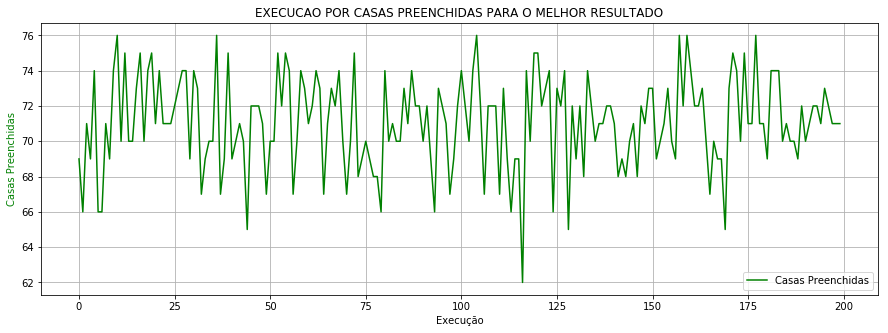

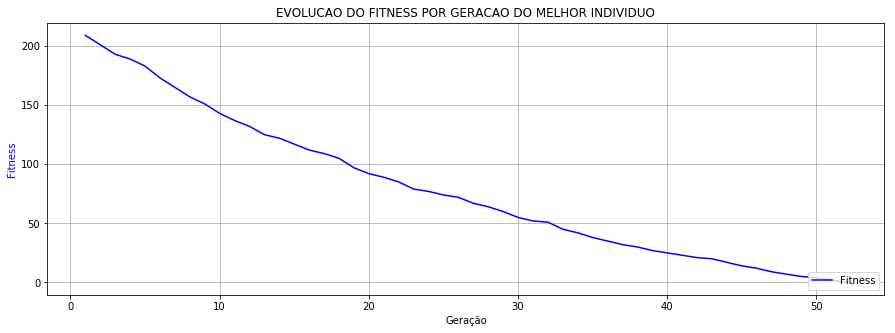

In [12]:
plot_run(execution)

#### K = 5

In [11]:
execution = run(5)

TEMPO TOTAL: 120.1183s 	| TEMPO MÉDIO: 0.6006s 	| CONVERGIU: False


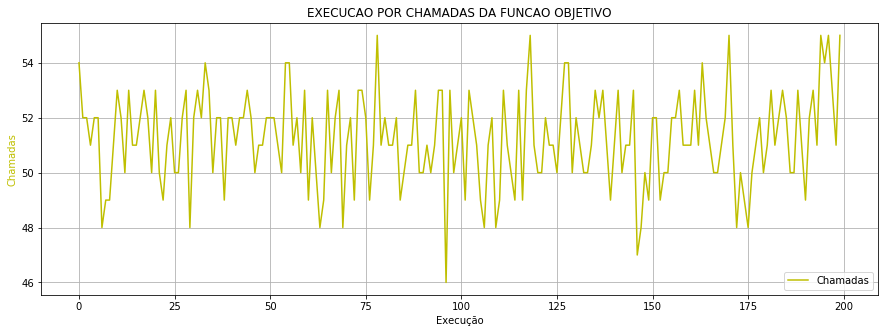

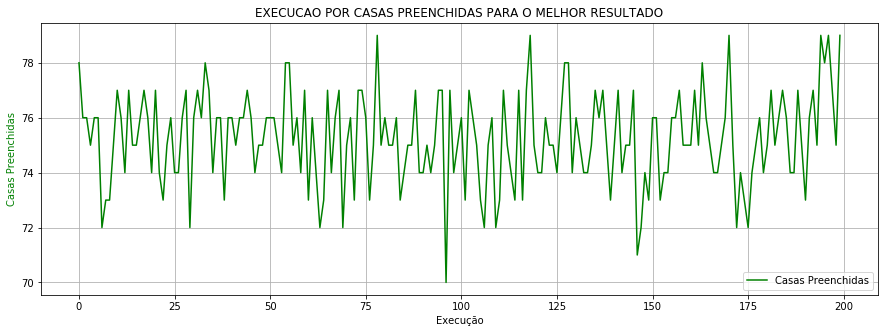

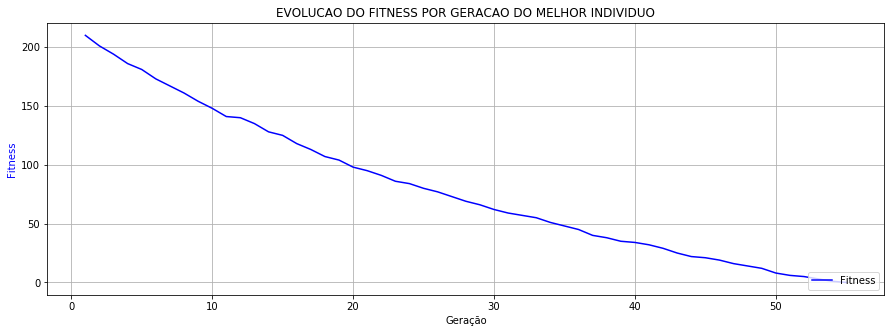

In [12]:
plot_run(execution)

#### K = 10

In [13]:
execution = run(10)

TEMPO TOTAL: 479.6518s 	| TEMPO MÉDIO: 2.3983s 	| CONVERGIU: False


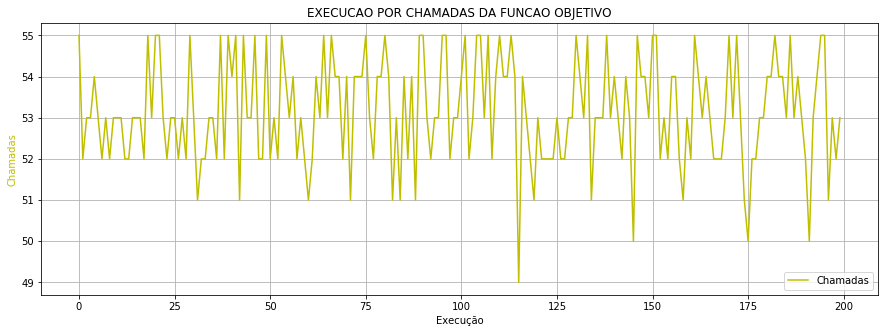

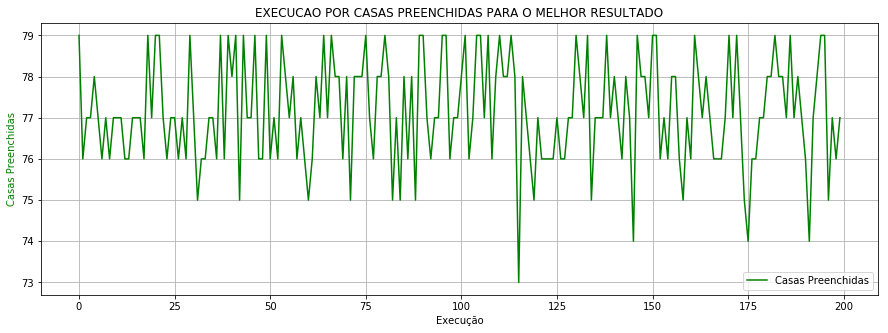

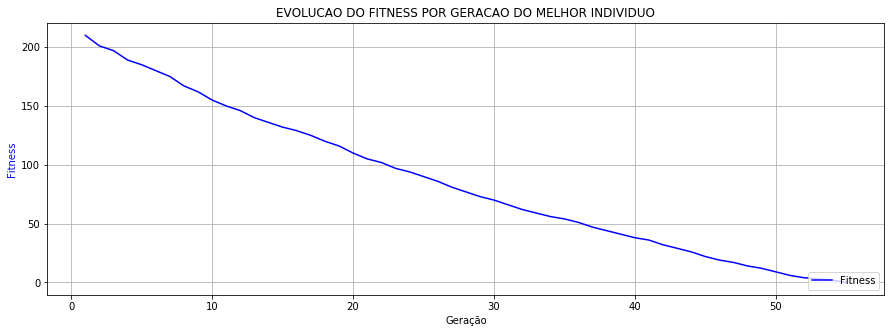

In [14]:
plot_run(execution)

#### K = 25

In [15]:
execution = run(25)

TENTATIVA: 70 	| CONVERGIU: True
SOLUCAO:
8 3 7 |1 9 4 |6 2 5 
5 4 9 |6 2 3 |7 8 1 
6 2 1 |7 8 5 |9 3 4 
------+------+------
2 5 6 |8 1 7 |4 9 3 
4 1 3 |5 6 9 |2 7 8 
9 7 8 |3 4 2 |5 1 6 
------+------+------
1 6 4 |2 7 8 |3 5 9 
7 9 5 |4 3 1 |8 6 2 
3 8 2 |9 5 6 |1 4 7 


TEMPO TOTAL: 981.422s 	| TEMPO MÉDIO: 13.8228s 	| CONVERGIU: True


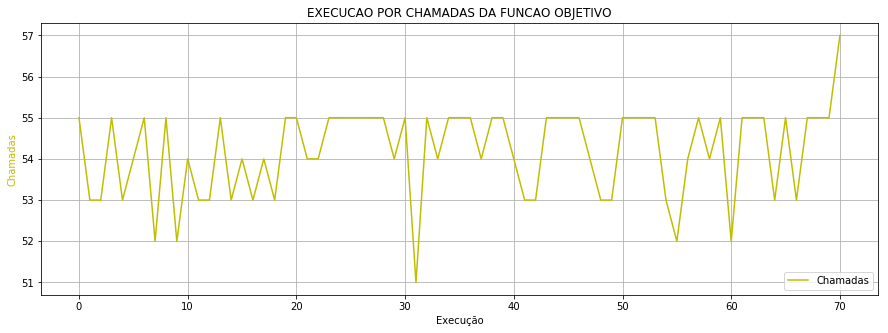

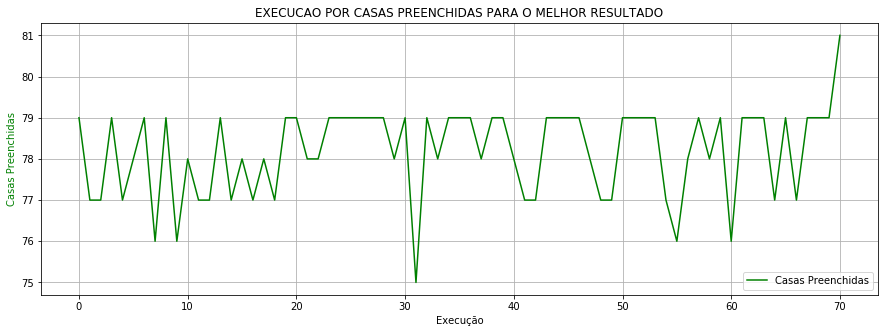

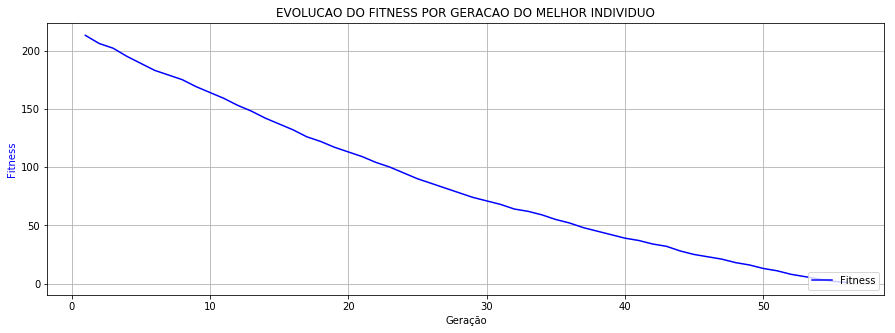

In [16]:
plot_run(execution)

#### K = 50

In [17]:
execution = run(50)

TENTATIVA: 10 	| CONVERGIU: True
SOLUCAO:
8 3 7 |1 9 4 |6 2 5 
5 4 9 |6 2 3 |7 8 1 
6 2 1 |7 8 5 |9 3 4 
------+------+------
2 5 6 |8 1 7 |4 9 3 
4 1 3 |5 6 9 |2 7 8 
9 7 8 |3 4 2 |5 1 6 
------+------+------
1 6 4 |2 7 8 |3 5 9 
7 9 5 |4 3 1 |8 6 2 
3 8 2 |9 5 6 |1 4 7 


TEMPO TOTAL: 674.0106s 	| TEMPO MÉDIO: 61.2737s 	| CONVERGIU: True


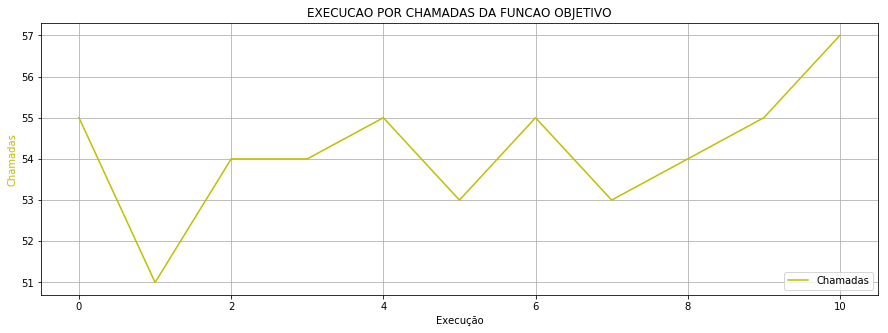

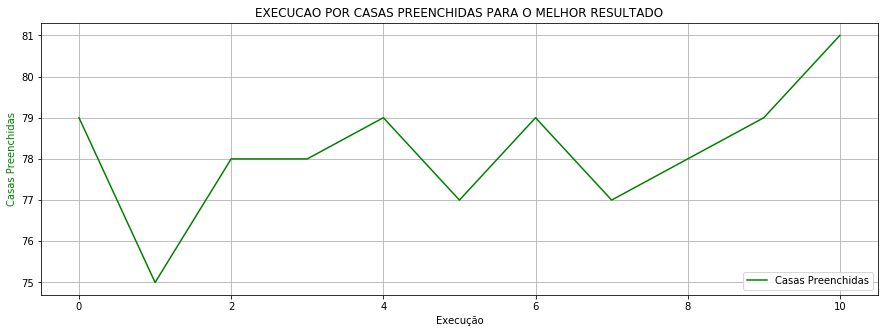

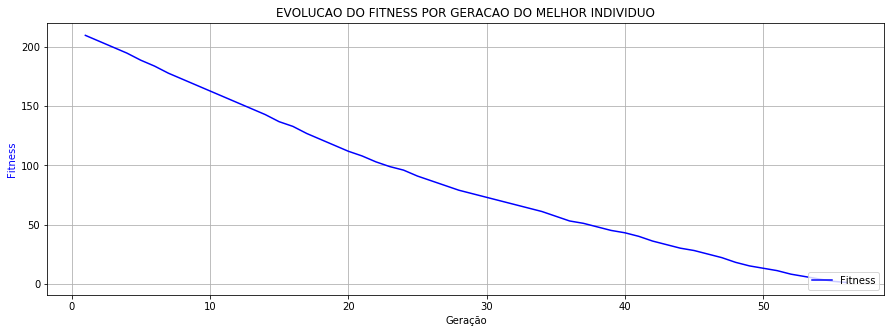

In [18]:
plot_run(execution)

## Considerações
A Busca em Feixe Local não mostrou-se uma boa solução para  esse problema pois com um tamanho de feixe pequeno a chance de se chegar em um máximo local é muito alta(todas as vezes rodadas chegou-se em um máximo local), mesmo com a estratégia estocástica utilizada na geração dos filhos de escolher aleatoriamente uma casa e um dígito a ser colocado  nessa casa. Somente com um feixe de tamanho na faixa maior que 25 pode-se chegar em uma solução, onde é possível assim(com essa quantidade de filhos) varrer de  forma mais abrangente o espaço de busca, mas devido a abordagem aleatória ainda assim não é garantida a convergência, assim como a convergência pode ocorrer com feixe de tamanho pequeno.  

Como a função para gerar os filhos é custosa, devido à necessidade de gerar filhos válidos e portanto percorrer todo o puzzle para verificar as possibilidades, o algoritmo fica lento.  

Em uma outra implementação utilizando **constraint propagation** conseguiu-se obter a solução muito mais rapidamente e em menos passos, mostrando-se assim como uma abordagem mais adequada para esse problema.

Vale salientar que a quantidade de casas preenchidas por execução e quantidade da chamada da função objetivo são proporcionais, pois cada filho gerado, incrementa uma casa preechida no puzzle e toda vez que isso ocorre chama-se a função objetivo para o melhor filho somente. Por isso delta_y das duas funções é de 24 unidades corresponde às casa já preenchidas do puzzle.